In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
import pandas as pd
import seaborn as sns
import numpy as np
#import gseapy as gp
import re
from sequencing_tools.viz_tools import okabeito_palette, color_encoder, simpsons_palette, cor_plot
from sequencing_tools.stats_tools import normalize_count
from plotting_utils import label_sample
from sklearn.metrics.pairwise import cosine_similarity

#def label_sample(x):
#    if 'HS' in x:
#        return 'High salt'
#    elif 'Frag' in x:
#        return 'Fragmented'
#    elif re.search('N[aA]', x):
#        return 'Alkaline hydrolysis'
#    elif re.search('L[0-9E]+',x):
#        return 'PolyA-selected'
#    elif re.search('Exo|ED|DE', x):
#        return 'Exonuclease I'
#    elif 'Phos' in x:
#        return 'Phosphatase'
#    elif 'All' in x:
#        return 'Untreated'
#    elif 'PEV' in x:
#        return 'Plasma EV'
#    else:
#        return 'Unfragmented'

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize =15)
plt.rc('ytick', labelsize = 15)
colors = okabeito_palette()
colors.append('black')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
project_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map'
count_file = project_path + '/Counts/combined_gene_count.tsv'
#    .assign(grouped_type = lambda d: np.where(d.name.str.startswith('MT-'), 'MT', d.grouped_type))\


count_df = pd.read_table(count_file) \
    .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
    .assign(grouped_type = lambda d: np.where(d.type == "Mt_tRNA", 'Mt', d.grouped_type))
count_df.iloc[:,4:] = normalize_count(count_df.iloc[:,4:])
count_df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/numpy/lib/shape_base.py:357: RuntimeWarning: divide by zero encountered in log
  res = asanyarray(func1d(inarr_view[ind0], *args, **kwargs))
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/numpy/lib/shape_base.py:380: RuntimeWarning: divide by zero encountered in log
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


,id,grouped_type,type,name,IGG_cf_R1_001,MPCEV_R1_001,MPF10_R1_001,MPF4_R1_001,PPCEV_R1_001,PPF10_R1_001,...,Qcf_NA2_R1_001,Qcf_NA3_R1_001,Qcf_NA4_R1_001,Qcf_Na1_R1_001,Qcf_Phos1_R1_001,Qcf_Phos2_R1_001,Qcf_Phos3_R1_001,S96_cfD_R1_001,S96_cf_R1_001,genome_sim_R1_001
0,18S_rRNA,rRNA,18S_rRNA,18S_rRNA,131651.838968,254990.830997,43514.899839,67496.500662,3.566754e+05,2.799526e+05,...,20709.977143,29330.779256,29330.779256,29330.779256,41446.893429,108365.463340,108695.888933,62368.459775,56166.174918,7967.969593
1,28S_rRNA,rRNA,28S_rRNA,28S_rRNA,257733.792442,393709.168369,80403.839799,108021.172106,6.051472e+05,4.590755e+05,...,42755.298650,65546.173484,63257.745492,64561.964742,117878.230817,387712.469333,386223.373839,167760.639241,150997.154430,17218.917341
2,5.8S_rRNA,rRNA,5.8S_rRNA,5.8S_rRNA,71227.020570,397185.629017,132291.370889,133252.883310,1.543838e+06,1.169401e+06,...,2998.455073,8698.020448,8814.134134,4826.189793,30052.689909,65166.286053,64767.659389,225644.338821,203114.861850,675.251660
3,5S_rRNA,rRNA,5S_rRNA,5S_rRNA,1350.275271,207113.921857,62994.082751,78305.310634,5.339519e+05,5.485114e+05,...,1420.320824,5018.494222,4962.964993,2677.756917,14448.739348,21293.380603,24528.185879,1576.373370,1399.450561,39907.373132
4,ENSG00000000003.14_2,Protein coding,protein_coding,TSPAN6,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,...,97.115954,284.662487,458.472517,295.798729,0.283935,0.000000,0.725954,0.000000,0.000000,7360.243099


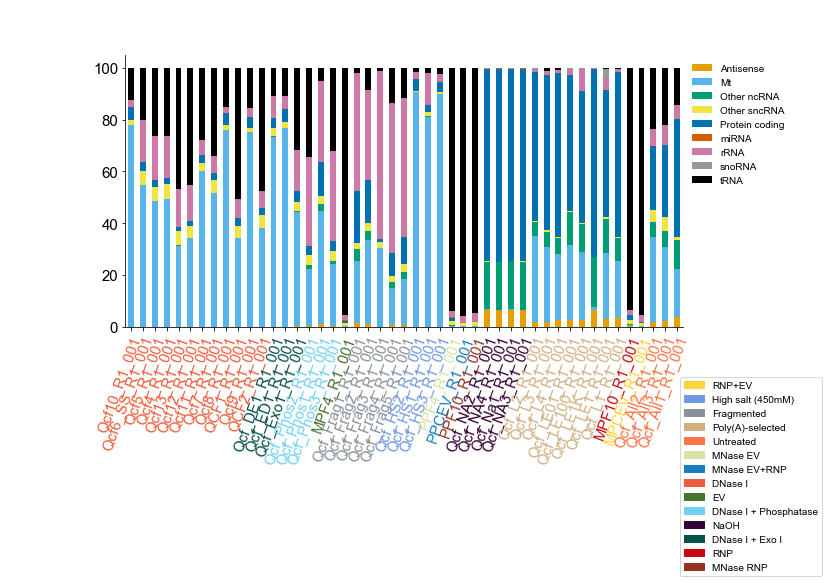

In [5]:
def percentage_columns(d):
    for col in d.columns:
        d[col] = d[col].transform(lambda x: 100*x/x.sum())
    return d

fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
bar_df = count_df.drop(['id','type','name'], axis=1)\
    .filter(regex = 'grouped|Q[cC][fF]|PEV|[PM]P')\
    .groupby('grouped_type')\
    .sum() \
    .pipe(percentage_columns)\
    .transpose() \
    .assign(treatment = lambda d: d.index.map(label_sample))
    
bar_df.sort_values('treatment')\
    .drop('treatment', axis=1)\
    .plot.bar(stacked=True, ax = ax, color = colors)
ax.legend(bbox_to_anchor = (1,1), frameon = False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, rotation_mode = 'anchor', ha ='right')
ce = color_encoder()
ce.fit_transform(bar_df.treatment, simpsons_palette())
for xt in ax.get_xmajorticklabels():
    color = ce.encoder[label_sample(xt.get_text())]
    xt.set_color(color)
sns.despine()
ax1 = fig.add_axes([0,0,1,1])
ax1.axis('off')
ce.show_legend(ax1, bbox_to_anchor=(1.1,0))

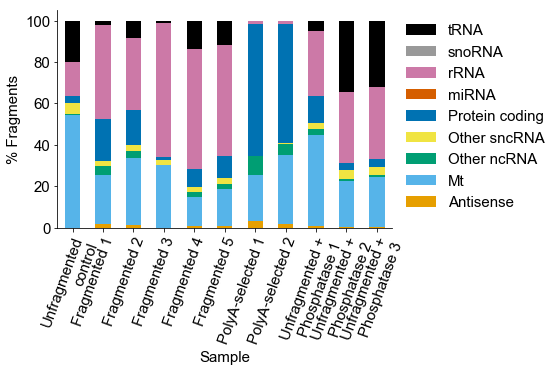

In [6]:
def rename_longRNA(name):
    try:
        x = name.split('_')[1]
        treatment = ''
    
        is_long = 0
        if 'Frag' in x:
            treatment = 'Fragmented'
            is_long = 1
        elif re.search('L[12]', x):
            treatment = 'PolyA-selected'
            is_long = 1
        elif re.search('Qcf[0-9]+|SS',name):
            treatment = 'Unfragmented\ncontrol'
            is_long = 0
        elif 'Phos' in x:
            treatment = 'Unfragmented +\nPhosphatase'
            is_long = 1
    
        if is_long == 1:
            return treatment +' ' + re.search('\d+', x).group(0)
        else:
            return treatment 
    except IndexError:
        return name
        

fig = plt.figure()
ax = fig.add_subplot(111)
count_df\
    .filter(regex = 'grouped|L[12]|Frag|SS|Phos')\
    .groupby('grouped_type')\
    .sum() \
    .pipe(percentage_columns)\
    .rename(columns = rename_longRNA)\
    .transpose() \
    .plot.bar(stacked=True, ax = ax, color = colors)
ax.legend(bbox_to_anchor = (1,1),  fontsize=15)
ax.set_xlabel('Sample')
ax.set_ylabel('% Fragments')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 70, ha = 'right', rotation_mode = 'anchor')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], frameon = False, bbox_to_anchor = (1,1), fontsize = 15)
sns.despine()

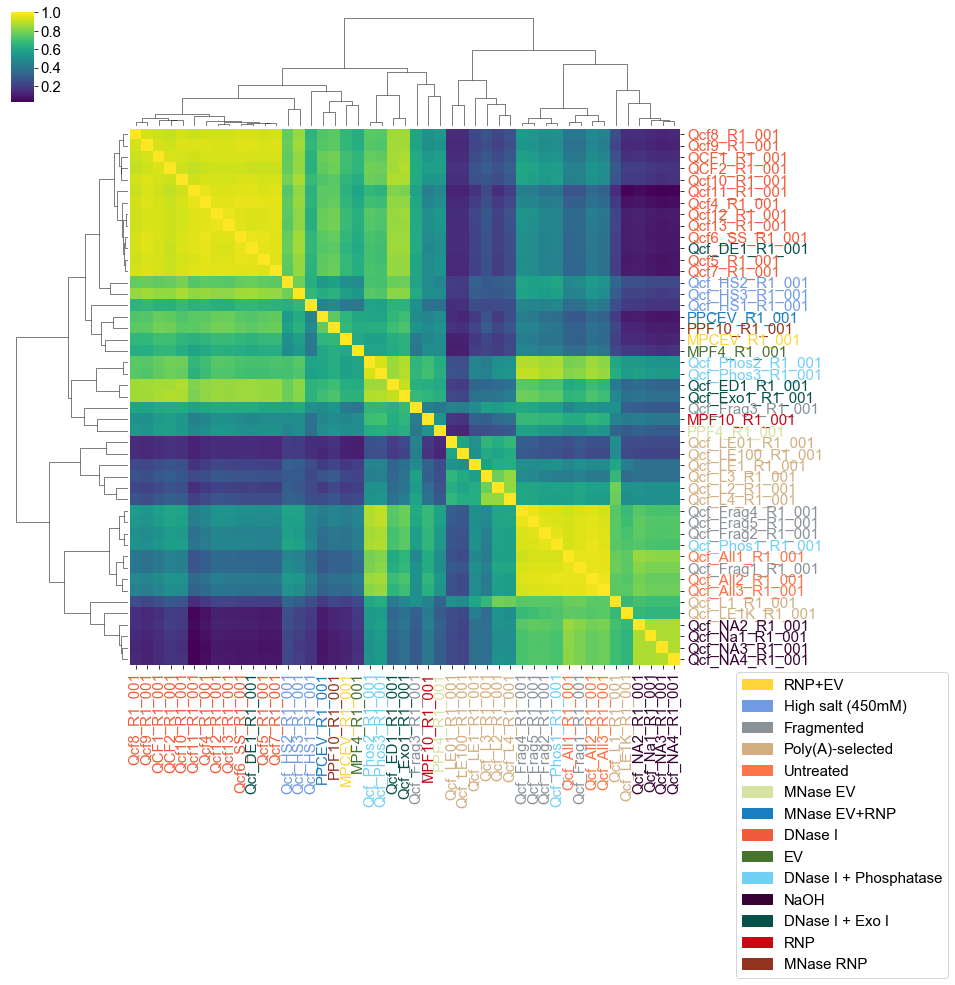

In [9]:
cor_df = count_df\
        .filter(regex = 'Qcf|QCF|[MP]P')\
        .transform(lambda x: np.log(x+1))\
        .corr(method ='pearson')
p = sns.clustermap(cor_df, cmap = 'viridis',figsize=(12,12))
ax = p.ax_heatmap
xt = ax.set_xticks(range(cor_df.shape[0]))
yt = ax.set_yticks(range(cor_df.shape[1]))
xt = ax.set_xticklabels(cor_df.columns[p.dendrogram_col.reordered_ind])
yt = ax.set_yticklabels(cor_df.index[p.dendrogram_row.reordered_ind])

yt = ax.set_yticks(np.arange(cor_df.shape[1])+0.5)
xt = ax.set_xticks(np.arange(cor_df.shape[0])+0.5)

ce = color_encoder()
ce.fit(cor_df.columns.map(label_sample), 
                 simpsons_palette())
for xt in ax.get_xmajorticklabels():
    color = ce.encoder[label_sample(xt.get_text())]
    xt.set_color(color)
    
for yt in ax.get_ymajorticklabels():
    color = ce.encoder[label_sample(yt.get_text())]
    yt.set_color(color)

pat = [mpatches.Patch(color=col, label=lab) for lab, col in ce.encoder.items()]
ax.legend(handles=pat, bbox_to_anchor = (1.5,0.), fontsize=15)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


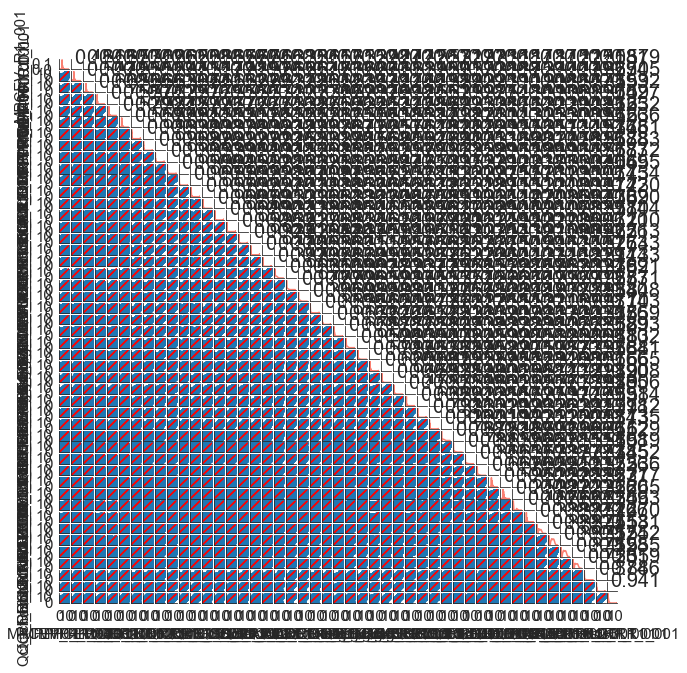

In [14]:
cor_df = count_df\
        .filter(regex = 'Qcf|QCF|[MP]P')\
        .transform(lambda x: np.log(x+1))

fig = plt.figure(figsize = (10,10))
cor_plot(cor_df, fig)

In [28]:
def count_to_tpm(count, length):
    rate = count/length
    tpm = rate/rate.sum() * 1e6 
    return tpm

gene_length = pd.read_table('/stor/work/Lambowitz/ref/hg19/genome/genes.length', 
                            names = ['id','glength'])
gene_length.head()

tpm_df = count_df\
    .filter(regex='id|grouped_type|type|name|L[12]|Frag|FQ') \
    .query('grouped_type == "Protein coding"')\
    .assign(id = lambda d: d.id.str.split('.', expand=True).iloc[:,0])\
    .merge(gene_length)
for col in tpm_df.columns:
    if 'Qcf' in col:
        tpm_df[col] = count_to_tpm(tpm_df[col], tpm_df['glength'])

In [29]:
gene_expr = '/stor/work/Lambowitz/cdw2854/EV_polyA/published_expr/rna_tissue.tsv'
expr_df = pd.read_table(gene_expr)
expr_df.head()

,Gene,Gene name,Sample,Value,Unit
0,ENSG00000000003,TSPAN6,adipose tissue,31.5,TPM
1,ENSG00000000003,TSPAN6,adrenal gland,26.4,TPM
2,ENSG00000000003,TSPAN6,appendix,9.2,TPM
3,ENSG00000000003,TSPAN6,bone marrow,0.7,TPM
4,ENSG00000000003,TSPAN6,breast,53.4,TPM


In [14]:
top_n = 80
tpm_cor_df = tpm_df\
    .filter(regex='id|Qcf')\
    .rename(columns = {'id':'Gene'})
cor_df = expr_df\
    .pipe(pd.pivot_table, columns = 'Sample', 
          index=['Gene'], values='Value') \
    .reset_index() \
    .merge(tpm_cor_df, on ='Gene', how ='inner')\
    .sort_values('Qcf_L1_R1_001', ascending=False)\
    .iloc[:, 1:]\
    .transform(lambda x: np.log(x+1))\
    .corr(method = 'pearson')\
    .filter(regex = 'Qcf|Frag') \
    .reset_index() \
    .pipe(lambda d: d[~d['index'].str.contains('Qcf')])\
    .sort_values('Qcf_L1_R1_001', ascending=False)\
    .head(top_n)
cor_df.index = cor_df['index']
cor_df

,index,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_Frag3_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001
index,,,,,,
bone marrow,bone marrow,0.131160,0.157900,0.511860,0.538196,0.545941
lymph node,lymph node,0.114303,0.147163,0.460169,0.494106,0.491961
spleen,spleen,0.128920,0.158915,0.464818,0.492320,0.491132
appendix,appendix,0.126548,0.161398,0.456402,0.487029,0.486811
tonsil,tonsil,0.104536,0.140618,0.444294,0.482303,0.477978
salivary gland,salivary gland,0.144978,0.162432,0.447138,0.462682,0.479063
adipose tissue,adipose tissue,0.129223,0.160128,0.433668,0.461754,0.461410
colon,colon,0.122365,0.154892,0.430062,0.461212,0.468009
urinary bladder,urinary bladder,0.115064,0.152366,0.426732,0.458810,0.454626


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(1,0.6,"Spearman's $\\rho$")

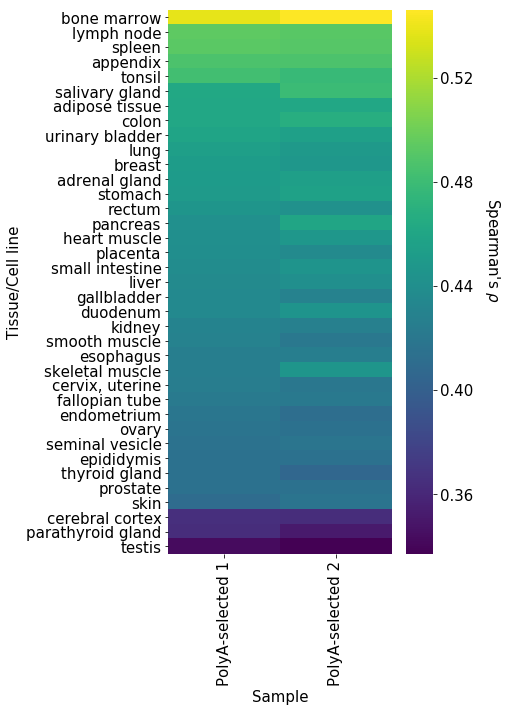

In [15]:
fig = plt.figure(figsize = (5,10))
ax = fig.add_subplot(111)
sns.heatmap(cor_df.filter(regex = 'L[12]').rename(columns = rename_longRNA),
           cmap = 'viridis', ax = ax)
ax.set_xlabel('Sample')
ax.set_ylabel('Tissue/Cell line')
yt = ax.set_yticks(np.arange(cor_df.shape[0])+0.5)
yt = ax.set_yticklabels(cor_df['index'].values, fontsize=15)
fig.text(1,0.6, r"Spearman's $\rho$", rotation = 270, fontsize=15)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(46,0.5,'Tissue/Cell line')

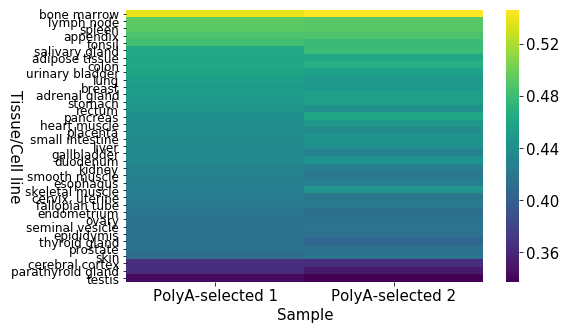

In [16]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
sns.heatmap(cor_df.filter(regex = 'L[12]').rename(columns = rename_longRNA),
               cmap = 'viridis', ax = ax)
yt = ax.set_yticks(np.arange(cor_df.shape[0])+0.5)
yt = ax.set_yticklabels(cor_df['index'].values, fontsize=12)#[p.dendrogram_row.reordered_ind])
ax.set_xlabel('Sample')
ax.set_ylabel('Tissue/Cell line', rotation=270)
#fig.text(0.08,0.85, r"Spearman's $\rho$", rotation = 90, fontsize=15)

In [17]:
tpm_df.head()

,id,grouped_type,type,name,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_Frag3_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001,glength
0,ENSG00000000003,Protein coding,protein_coding,TSPAN6,28.509875,20.841331,0.000000,1.146028,0.236566,11321
1,ENSG00000000005,Protein coding,protein_coding,TNMD,11.672152,17.381210,0.734198,0.286729,0.355124,15083
2,ENSG00000000419,Protein coding,protein_coding,DPM1,14.864157,7.747068,2.337450,6.572533,1.582841,23688
3,ENSG00000000457,Protein coding,protein_coding,SCYL3,15.776599,11.746608,0.000000,1.162665,0.240001,44636
4,ENSG00000000460,Protein coding,protein_coding,C1orf112,20.939246,13.655915,0.288419,6.037353,0.725428,191976


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


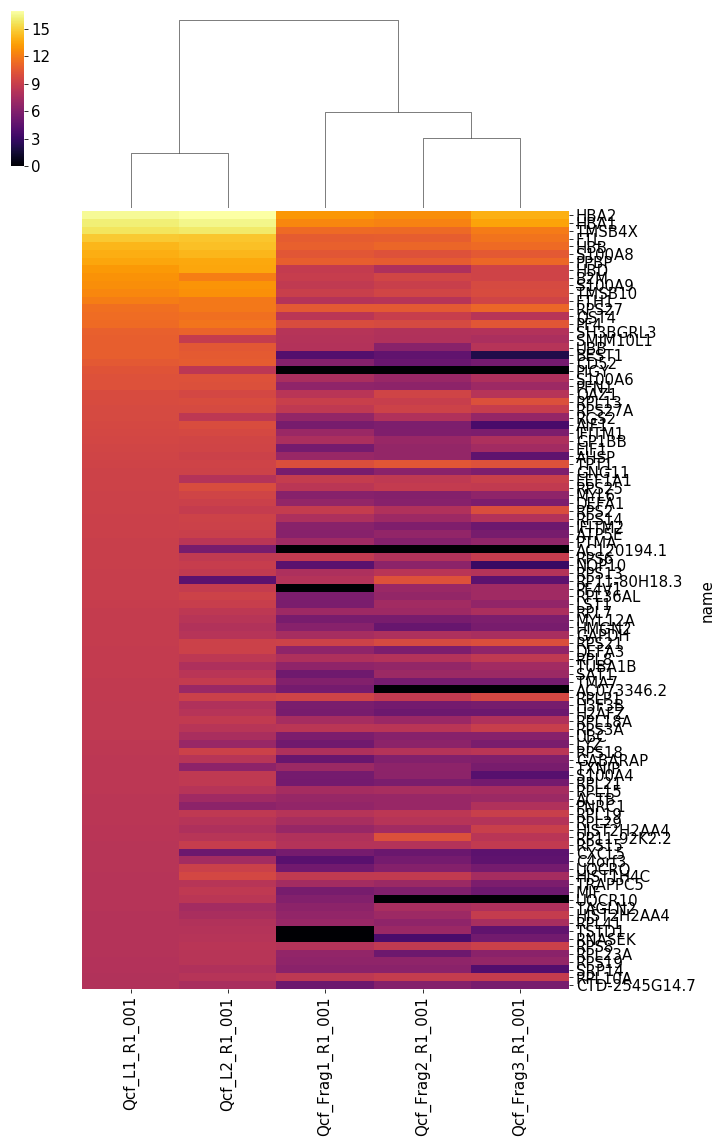

In [18]:
top_n = 100
hd = tpm_df\
    .sort_values('Qcf_L1_R1_001', ascending=False)\
    .query('type == "protein_coding"')\
    .pipe(lambda d: d[~d.name.str.contains('^MT')])
hd.index = hd.name

p = sns.clustermap(np.log2(hd\
                           .head(top_n)\
                           .filter(regex = 'Q')+1),
              row_cluster=False,
              cmap='inferno',
              figsize = (10,18))
ax = p.ax_heatmap
yt = ax.set_yticks(np.arange(top_n) +0.5)
yt = ax.set_yticklabels(hd.index[:top_n])

In [19]:
samplename = 'Qcf_L1_R1_001'

tpm_df = count_df\
    .assign(id = lambda d: d.id.str.split('.', expand=True).iloc[:,0])\
    .filter(regex='id|grouped_type|type|name|L[12]|Frag|FQ') \
    .merge(gene_length) \
    .query('type == "protein_coding"')
for col in tpm_df.columns:
    if 'Qcf' in col:
        tpm_df[col] = count_to_tpm(tpm_df[col], tpm_df['glength'])
tpm_df.sort_values('Qcf_L1_R1_001', ascending=False).head()


rank_df = expr_df\
    .pipe(lambda d: d[np.in1d(d.Sample, ['bone marrow', 'lymph node', 'spleen'])])\
    .rename(columns = {'Gene':'id',
                       'Gene name':'name'})\
    .groupby(['id','name'], as_index=False)\
    .agg({'Value':'mean'})\
    .filter(['id','name','Value'])\
    .merge(hd\
            .loc[:,['id','name',samplename]],
          on = ['id','name']) \
    .assign(rank = lambda d: d[samplename].rank() - d['Value'].rank()) \
    .sort_values('rank', ascending=False)
rank_df.head(20)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: 'name' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


,id,name,Value,Qcf_L1_R1_001,rank
18378,ENSG00000255072,PIGY,0.0,1301.422462,17656.5
18692,ENSG00000267697,LUZP6,0.0,172.006186,17524.5
5791,ENSG00000127530,OR7C1,0.0,60.911647,17273.5
17227,ENSG00000206106,KRTAP22-2,0.0,59.242835,17262.5
14249,ENSG00000180934,OR56A1,0.0,52.543412,17212.5
8896,ENSG00000148826,NKX6-2,0.0,51.525738,17205.5
12501,ENSG00000170790,OR10A2,0.0,49.331486,17181.5
18376,ENSG00000255012,OR5M1,0.0,41.100890,17128.5
17602,ENSG00000221836,OR2A5,0.0,34.187565,17050.0
17609,ENSG00000221858,OR2A12,0.0,33.107958,17025.5


In [20]:
cor_df = expr_df\
    .pipe(pd.pivot_table, columns = 'Sample', 
          index=['Gene', 'Gene name'], values='Value') \
    .reset_index() \
    .pipe(lambda d: d[~d['Gene name'].str.contains('^MT')])\
    .merge(tpm_cor_df.rename(columns=rename_longRNA), on ='Gene', how ='inner') \
    .sort_values('PolyA-selected 1', ascending=False)
cor_df.index= cor_df['Gene name']
cor_df.head(10)

,Gene,Gene name,adipose tissue,adrenal gland,appendix,bone marrow,breast,cerebral cortex,"cervix, uterine",colon,...,stomach,testis,thyroid gland,tonsil,urinary bladder,Fragmented 1,Fragmented 2,Fragmented 3,PolyA-selected 1,PolyA-selected 2
Gene name,,,,,,,,,,,,,,,,,,,,,
HBA2,ENSG00000188536,HBA2,226.0,336.7,218.0,18369.0,213.0,59.0,73.2,78.2,...,32.4,13.3,55.4,8.2,28.5,8907.952952,7108.415397,15962.845697,107737.317185,131261.231203
HBA1,ENSG00000206172,HBA1,142.9,233.6,143.1,17119.3,110.9,48.3,34.8,58.1,...,20.4,9.4,35.4,3.9,17.1,5993.821075,5137.355150,11652.587194,73124.866519,94492.867360
TMSB4X,ENSG00000205542,TMSB4X,3805.9,5439.9,6688.8,5468.2,3675.2,2891.0,4421.5,4173.9,...,4224.3,928.3,1529.5,6487.7,5915.7,2714.016813,2598.101270,4264.419622,56821.483274,63275.020289
FTL,ENSG00000087086,FTL,4755.5,2291.2,3208.8,2600.5,2719.6,1997.8,2925.6,2081.9,...,1280.3,889.4,2427.0,1209.1,3753.2,1674.550446,1745.522065,3454.889331,29993.366309,26504.855510
HBB,ENSG00000244734,HBB,627.5,654.3,306.3,78046.6,854.1,85.0,283.8,266.8,...,48.9,30.1,456.2,37.1,180.5,1955.625387,2320.833247,2726.924064,18599.296322,23839.844915
S100A8,ENSG00000143546,S100A8,464.5,22.0,1232.5,14915.7,36.9,11.7,176.7,25.4,...,10.9,13.0,12.6,4867.3,166.9,1396.022039,1179.269990,1551.879197,15424.610053,18969.579497
PPBP,ENSG00000163736,PPBP,2.3,1.4,1.6,110.6,1.1,0.5,0.1,0.2,...,0.1,0.0,1.6,0.0,0.7,1848.105856,1673.848013,2503.332780,13004.032292,13238.326570
HBD,ENSG00000223609,HBD,0.1,0.3,0.7,1221.3,0.0,0.0,0.0,0.4,...,0.2,0.1,0.1,0.1,0.1,468.684746,243.462844,666.408749,9378.809786,12565.101438
B2M,ENSG00000166710,B2M,1090.6,1575.8,2639.0,2345.3,510.2,379.5,670.9,1107.7,...,851.9,525.4,1761.0,2671.5,3941.4,503.569503,740.427096,665.930678,7584.051574,4573.875461


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


AttributeError: 'AxesSubplot' object has no attribute 'dendrogram_col'

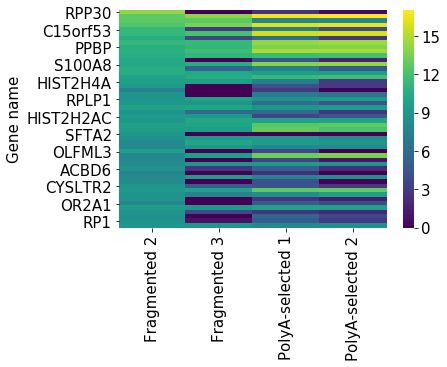

In [21]:
top_n = 50
p = sns.heatmap(np.log2(cor_df.sort_values('Fragmented 1', ascending=False).iloc[:top_n,-4:]+1),
                  cmap = 'viridis')
yt = ax.set_yticks(np.arange(top_n)+0.5)
xt = ax.set_xticks(np.arange(4) + 0.5)
xt = ax.set_xticklabels(cor_df.columns[-4:].str.capitalize()[p.dendrogram_col.reordered_ind])
yt = ax.set_yticklabels(cor_df.index[:top_n], fontsize=9)
ax.set_ylabel('Gene', rotation = 270)
p.fig.text(0.1,0.85, r'TPM ($log_2$)', rotation = 90, fontsize=15)

In [ ]:
top_n = 100
p = sns.clustermap(np.log2(cor_df.iloc[:top_n,2:]+1),
                   row_cluster=False,
                  figsize = (10,17),
                  cmap = 'inferno')
ax = p.ax_heatmap
xt = ax.set_yticks(np.arange(top_n)+0.5)
yt = ax.set_xticks(np.arange(cor_df.shape[1] - 2) + 0.5)
xt = ax.set_xticklabels(cor_df.columns[2:].str.capitalize()[p.dendrogram_col.reordered_ind])
yt = ax.set_yticklabels(cor_df.index[:top_n], fontsize=9)
ax.set_ylabel('Gene', rotation = 270)
p.fig.text(0.1,0.85, r'TPM ($log_2$)', rotation = 90, fontsize=15)

In [112]:
cor_df

,Gene,Gene name,adipose tissue,adrenal gland,appendix,bone marrow,breast,cerebral cortex,"cervix, uterine",colon,...,spleen,stomach,testis,thyroid gland,tonsil,urinary bladder,Fragmented 1,Fragmented 2,PolyA-selected 1,PolyA-selected 2
Gene name,,,,,,,,,,,,,,,,,,,,,
HBA2,ENSG00000188536,HBA2,226.0,336.7,218.0,18369.0,213.0,59.0,73.2,78.2,...,427.2,32.4,13.3,55.4,8.2,28.5,8026.927527,6324.371397,104296.825453,127353.270484
HBA1,ENSG00000206172,HBA1,142.9,233.6,143.1,17119.3,110.9,48.3,34.8,58.1,...,303.5,20.4,9.4,35.4,3.9,17.1,5401.012739,4570.715152,70786.398891,91679.588751
TMSB4X,ENSG00000205542,TMSB4X,3805.9,5439.9,6688.8,5468.2,3675.2,2891.0,4421.5,4173.9,...,10744.7,4224.3,928.3,1529.5,6487.7,5915.7,2445.591751,2311.535897,55004.383216,61391.171634
FTL,ENSG00000087086,FTL,4755.5,2291.2,3208.8,2600.5,2719.6,1997.8,2925.6,2081.9,...,5838.2,1280.3,889.4,2427.0,1209.1,3753.2,1743.654730,1907.964637,33310.890454,29864.665493
HBB,ENSG00000244734,HBB,627.5,654.3,306.3,78046.6,854.1,85.0,283.8,266.8,...,720.7,48.9,30.1,456.2,37.1,180.5,1762.207697,2064.849982,18004.507512,23130.075727
S100A8,ENSG00000143546,S100A8,464.5,22.0,1232.5,14915.7,36.9,11.7,176.7,25.4,...,786.1,10.9,13.0,12.6,4867.3,166.9,1257.950933,1049.198869,14931.344862,18404.809756
PPBP,ENSG00000163736,PPBP,2.3,1.4,1.6,110.6,1.1,0.5,0.1,0.2,...,24.3,0.1,0.0,1.6,0.0,0.7,1665.322196,1489.225925,12588.175006,12844.189933
HBD,ENSG00000223609,HBD,0.1,0.3,0.7,1221.3,0.0,0.0,0.0,0.4,...,2.2,0.2,0.1,0.1,0.1,0.1,422.330305,216.609379,9078.883863,12191.008323
S100A9,ENSG00000163220,S100A9,794.0,53.5,2087.4,20959.3,51.3,20.9,255.9,42.7,...,1188.6,17.2,16.6,29.3,3911.6,1006.1,449.968937,632.179900,7689.407847,8777.180172


In [113]:
tpm_df.head()

,id,grouped_type,type,name,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001,glength
3,ENSG00000000003,Protein coding,protein_coding,TSPAN6,26.444522,18.894833,1.113447,0.230170,11321
4,ENSG00000000005,Protein coding,protein_coding,TNMD,10.826582,15.757873,0.278577,0.345522,15083
5,ENSG00000000419,Protein coding,protein_coding,DPM1,13.787346,7.023523,6.385679,1.760048,23688
6,ENSG00000000457,Protein coding,protein_coding,SCYL3,14.633689,10.649521,1.129611,0.233511,44636
7,ENSG00000000460,Protein coding,protein_coding,C1orf112,19.564105,12.504311,5.865714,0.705812,191976


Text(0.9,0.5,'TPM ($log_2$)')

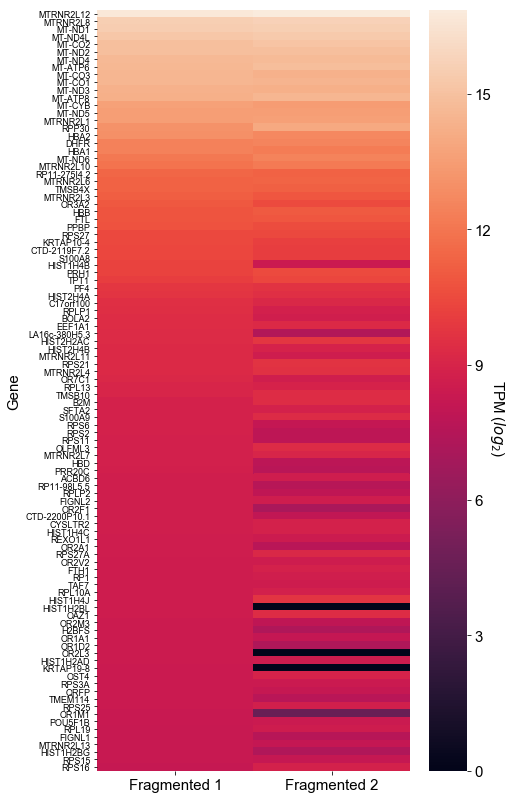

In [114]:
fig = plt.figure(figsize=(7,14))
ax = plt.subplot(111)
frag_df = tpm_df\
    .filter(regex='id|name|type|Frag')\
    .sort_values('Qcf_Frag1_R1_001', ascending=False)\
    .set_index('name')
p = sns.heatmap(np.log2(frag_df.iloc[:top_n,-2:]+1), ax =ax)
xt = ax.set_yticks(np.arange(top_n)+0.5)
yt = ax.set_xticks(np.arange(2) + 0.5)
xt = ax.set_xticklabels(frag_df.columns[-2:].map(rename_longRNA))
yt = ax.set_yticklabels(frag_df.index[:top_n], fontsize=9)
ax.set_ylabel('Gene', rotation = 90)
fig.text(0.9,0.5, r'TPM ($log_2$)', rotation = 270, fontsize=15)

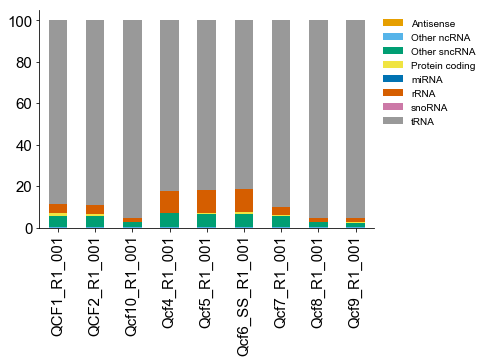

In [115]:
ax = plt.subplot(111)
count_df.filter(regex='grou|Q[cC][Ff][0-9]+')\
    .groupby('grouped_type')\
    .sum() \
    .pipe(percentage_columns)\
    .transpose() \
    .plot.bar(stacked=True, ax = ax, color = colors)
ax.legend(bbox_to_anchor = (1,1), frameon = False)
sns.despine()

In [61]:
dedup_df = pd.read_table('/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/Counts/all_counts/spreaded_all_counts.tsv')
dedup_df.head()

,gene_id,gene_name,gene_type,grouped_type,IGG-cf_R1_001:all:antisense,IGG-cf_R1_001:all:sense,IGG-cf_R1_001:dedup:antisense,IGG-cf_R1_001:dedup:sense,QCF1_R1_001:all:antisense,QCF1_R1_001:all:sense,...,S96-cfD_R1_001:dedup:antisense,S96-cfD_R1_001:dedup:sense,S96-cf_R1_001:all:antisense,S96-cf_R1_001:all:sense,S96-cf_R1_001:dedup:antisense,S96-cf_R1_001:dedup:sense,genome-sim_R1_001:all:antisense,genome-sim_R1_001:all:sense,genome-sim_R1_001:dedup:antisense,genome-sim_R1_001:dedup:sense
0,.,.,No features,No features,0,0,0,0,1164939,69311,...,0,0,0,0,0,0,26647609,26664118,26647609,26664118
1,.,.,tRNA,tRNA,0,0,0,0,10237961,0,...,0,0,0,0,0,0,568,0,568,0
2,.,No features:.,Repeats,Repeats,3745,4542,2989,3742,35812,17223,...,94446,92684,159513,155574,101781,100419,16867723,16876133,16867723,16876133
3,18S_rRNA,18S_rRNA,rDNA,rRNA,0,0,0,0,734,175520,...,0,0,0,0,0,0,225,252,225,252
4,28S_rRNA,28S_rRNA,rDNA,rRNA,0,0,0,0,1089,384807,...,0,0,0,0,0,0,506,533,506,533


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


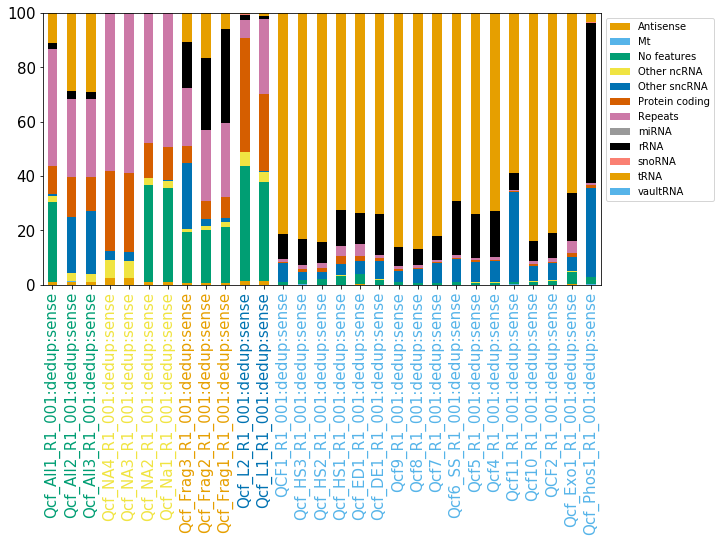

In [62]:
from tgirt_map.table_tool import change_gene_type
from sequencing_tools.viz_tools import color_encoder, simpsons_palette

def label_treatment(x, return_label=False):
    if 'All' in x:
        return 'Total nucleic acid' if return_label else 1
    elif re.search('NA|Na', x):
        return 'Alkaline hydrolysis' if return_label else 2
    elif re.search('Frag|frag', x):
        return 'Fragmented' if return_label else 3
    elif re.search('L[12]', x):
        return 'PolyA-selected' if return_label else 4
    else:
        return 'DNase-treatment' if return_label else 5

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
colors.append('salmon')
subset_dedup_df = dedup_df\
    .assign(gene_type = lambda d: d.gene_type.map(change_gene_type))\
    .filter(regex = 'type|Qcf|QCF')\
    .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
    .groupby('grouped_type')\
    .sum() \
    .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
    .pipe(lambda d: d[d.columns[d.columns.str.contains('dedup')]])\
    .pipe(percentage_columns)\

subset_dedup_df\
    .transpose() \
    .assign(prep = lambda d: d.index.map(label_treatment))\
    .sort_values('prep')\
    .drop('prep', axis=1)\
    .plot.bar(stacked=True, ax = ax, color = colors)
ax.legend(bbox_to_anchor = (1,1))

preps = [label_treatment(_.get_text(), return_label=True) for _ in ax.get_xmajorticklabels()]
ce = color_encoder()
ce.fit(preps)
for _, pre in zip(ax.get_xmajorticklabels(),preps):
    _.set_color(ce.encoder[pre])

In [118]:
dedup_df\
    .filter(regex='gene|HS.*dedup.*sense')\
    .sort_values('Qcf_HS1_R1_001:dedup:sense',ascending=False)\
    .pipe(lambda d: d[d.gene_type.str.contains('protein')])

,gene_id,gene_name,gene_type,Qcf_HS1_R1_001:dedup:antisense,Qcf_HS1_R1_001:dedup:sense,Qcf_HS2_R1_001:dedup:antisense,Qcf_HS2_R1_001:dedup:sense,Qcf_HS3_R1_001:dedup:antisense,Qcf_HS3_R1_001:dedup:sense
29253,ENSG00000228716.6_3,DHFR,protein_coding,0,689,0,2493,2,2534
53201,ENSG00000269028.3_2,MTRNR2L12,protein_coding,0,640,2,2220,0,2181
45040,ENSG00000255823.4_3,MTRNR2L8,protein_coding,0,216,0,759,0,725
45401,ENSG00000256618.2_2,MTRNR2L1,protein_coding,0,131,0,416,0,330
18078,ENSG00000198763.3,MT-ND2,protein_coding,0,75,13,553,8,711
18149,ENSG00000198888.2,MT-ND1,protein_coding,0,62,8,406,5,567
54010,ENSG00000270672.1_2,MTRNR2L6,protein_coding,0,36,0,105,0,93
18147,ENSG00000198886.2,MT-ND4,protein_coding,5,34,26,184,39,318
9227,ENSG00000148688.13_2,RPP30,protein_coding,0,29,0,67,0,69
53735,ENSG00000270188.1_2,MTRNR2L11,protein_coding,0,27,0,42,0,55


In [119]:
subset_dedup_df\
    .reset_index()\
    .query('grouped_type == "Protein coding"')\
    .drop('grouped_type', axis=1)\
    .pipe(pd.melt) \
    .assign(label = lambda d: d.variable.map(label_sample))\
    .groupby('label', as_index=False)\
    .agg({'value':['min','max']})

label      value           
                              min        max
0  Alkaline hydrolysis  12.333201  12.454948
1        Exonuclease I   2.263385   3.659106
2           Fragmented   7.377040   8.026018
3            High salt   2.508258   3.522140
4       PolyA-selected  27.412613  40.406809
5         Unfragmented   0.931086   1.907198
6            Untreated  10.819417  10.819417

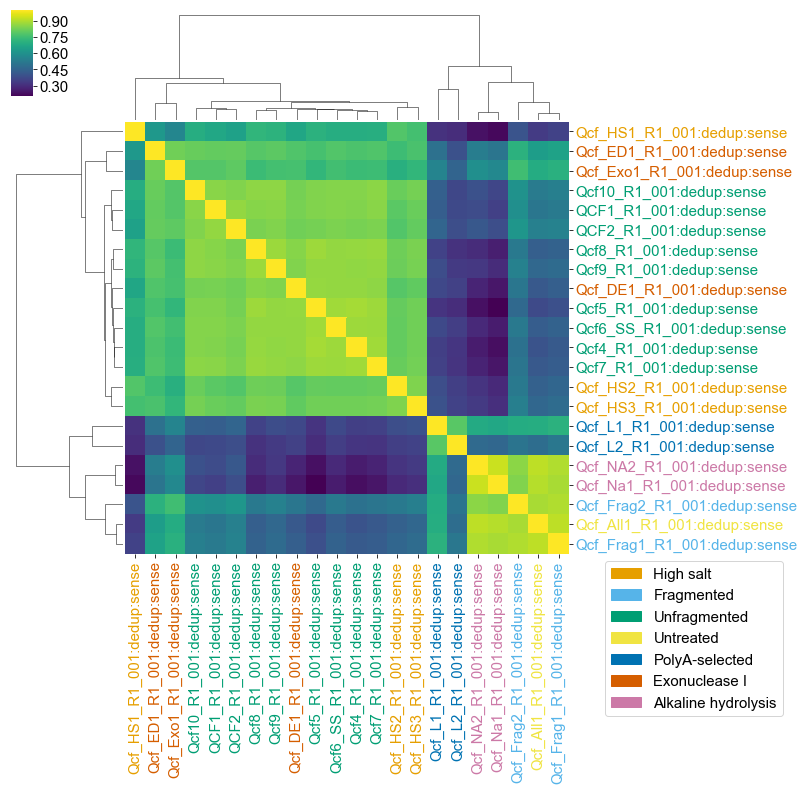

In [120]:
cor_df = np.log(dedup_df.filter(regex = 'Qcf|QCF').filter(regex='dedup:sense')+1).corr()
p = sns.clustermap(cor_df, cmap = 'viridis')
ax = p.ax_heatmap
xt = ax.set_xticks(range(cor_df.shape[0]))
yt = ax.set_yticks(range(cor_df.shape[1]))
xt = ax.set_xticklabels(cor_df.columns[p.dendrogram_col.reordered_ind])
yt = ax.set_yticklabels(cor_df.index[p.dendrogram_row.reordered_ind])

yt = ax.set_yticks(np.arange(cor_df.shape[1])+0.5)
xt = ax.set_xticks(np.arange(cor_df.shape[0])+0.5)

ce = color_encoder()
ce.fit(cor_df.columns.map(label_sample), 
                 okabeito_palette())
for xt in ax.get_xmajorticklabels():
    color = ce.encoder[label_sample(xt.get_text())]
    xt.set_color(color)
    
for yt in ax.get_ymajorticklabels():
    color = ce.encoder[label_sample(yt.get_text())]
    yt.set_color(color)

pat = [mpatches.Patch(color=col, label=lab) for lab, col in ce.encoder.items()]
ax.legend(handles=pat, bbox_to_anchor = (1.5,0.), fontsize=15)

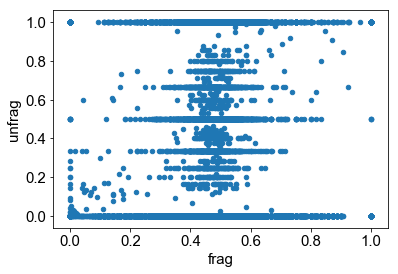

In [121]:
def frac(x, y):
    return x/(x+y)

sense_df = dedup_df\
    .filter(regex = 'Frag1.*dedup|QCF1_.*dedup|type|name|id')  \
    .assign(frag = lambda d: frac(d['Qcf_Frag1_R1_001:dedup:antisense'], d['Qcf_Frag1_R1_001:dedup:sense'])) \
    .assign(unfrag = lambda d: frac(d['QCF1_R1_001:dedup:antisense'],d['QCF1_R1_001:dedup:sense']))  \
    .query('grouped_type != "Repeats"') \
    .replace([np.inf, -np.inf], np.nan)\
    .fillna(0)
sense_df.plot.scatter('frag','unfrag')

In [122]:
sense_df.query('frag > unfrag').sort_values('frag', ascending=False).pipe(lambda d: d[d['QCF1_R1_001:dedup:antisense']>10])

,gene_id,gene_name,gene_type,grouped_type,QCF1_R1_001:dedup:antisense,QCF1_R1_001:dedup:sense,Qcf_Frag1_R1_001:dedup:antisense,Qcf_Frag1_R1_001:dedup:sense,frag,unfrag
12371,ENSG00000167995.15_2,BEST1,protein_coding,Protein coding,11,2,60,6,0.909091,0.846154
30156,ENSG00000230021.9_4,RP11-206L10.17,transcribed_processed_pseudogene,Other ncRNA,101,25,1160,232,0.833333,0.801587
3100,ENSG00000104904.12_4,OAZ1,protein_coding,Protein coding,225,126,188,42,0.817391,0.641026
55776,ENSG00000273734.1_5,LLfos-48D6.2,protein_coding,Protein coding,225,126,209,74,0.738516,0.641026
18056,ENSG00000198727.2,MT-CYB,protein_coding,Protein coding,13,39,235,504,0.317997,0.250000
18098,ENSG00000198804.2,MT-CO1,protein_coding,Protein coding,11,89,201,1210,0.142452,0.110000
4,5.8S_rRNA,5.8S_rRNA,rDNA,rRNA,35,12386,135,42997,0.003130,0.002818


In [123]:
count_df\
    .filter(regex='L[12]|Frag[12]|id|name') \
    .sort_values('Qcf_Frag1_R1_001', ascending=False)\
    .iloc[20:70,:]

,id,name,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001
60113,MT-TE,MT-TE,11009.0,25895.0,395.0,161.0
60555,TRV-CAC10-1,TRV-CAC10-1,10439.0,81311.0,175.0,43.0
60308,TRG-GCC5-1,TRG-GCC5-1,9380.0,50633.0,200.0,32.0
60533,TRU-TCA1-1,TRU-TCA1-1,8684.0,52832.0,362.0,74.0
50909,ENSG00000265150.1,RN7SL2,8621.0,11731.0,20.0,22.0
59344,ENSG00000283029.1_4,RN7SL1,8111.0,10146.0,24.0,32.0
60123,MT-TP,MT-TP,7460.0,11543.0,184.0,62.0
60334,TRIMET-CAT2-1,TRIMET-CAT2-1,6165.0,43491.0,257.0,60.0
29271,ENSG00000228716.6_3,DHFR,5892.0,7312.0,1505.0,2648.0
60301,TRG-CCC8-1,TRG-CCC8-1,5649.0,36167.0,197.0,41.0


In [ ]:
def cor_ntile(d):
    cor_coef = d.filter(regex = 'bone|Qc').corr(method='spearman')
    cor_coef = cor_coef.iloc[0,1]
    return pd.DataFrame({'ntile':[d.ntile.unique()[0]],
                         'cor':[cor_coef]})
    
    
fig = plt.figure()
ax = fig.add_subplot(111)
qcut_expr_df = expr_df\
    .pipe(pd.pivot_table, columns = 'Sample', 
          index=['Gene'], values='Value') \
    .reset_index() \
    .merge(tpm_df.rename(columns = {'id':'Gene'}), on ='Gene', how ='inner') \
    .filter(regex = 'name|glength|Gene|L1|bone marrow') \
    .assign(ntile = lambda d: pd.qcut(d.glength, 10, labels=False))\
    .assign(ntile = lambda d: d.ntile.astype(str))
    
qcut_expr_df.filter(regex = 'ntile|bone|Qc')\
    .groupby('ntile', as_index=False)\
    .apply(cor_ntile) \
    .plot.bar('ntile','cor', color = 'steelblue', ax = ax)
ax.legend().set_visible(False)
ax.set_xlabel('Gene length quantile group')
ax.set_ylabel(r"Spearman's $r_s$"\
              '\nbetween\nBone marrow (published) and\nPlasma (polyA-selected)')
sns.despine()

Text(0.5,1,'Quantile group: 9')

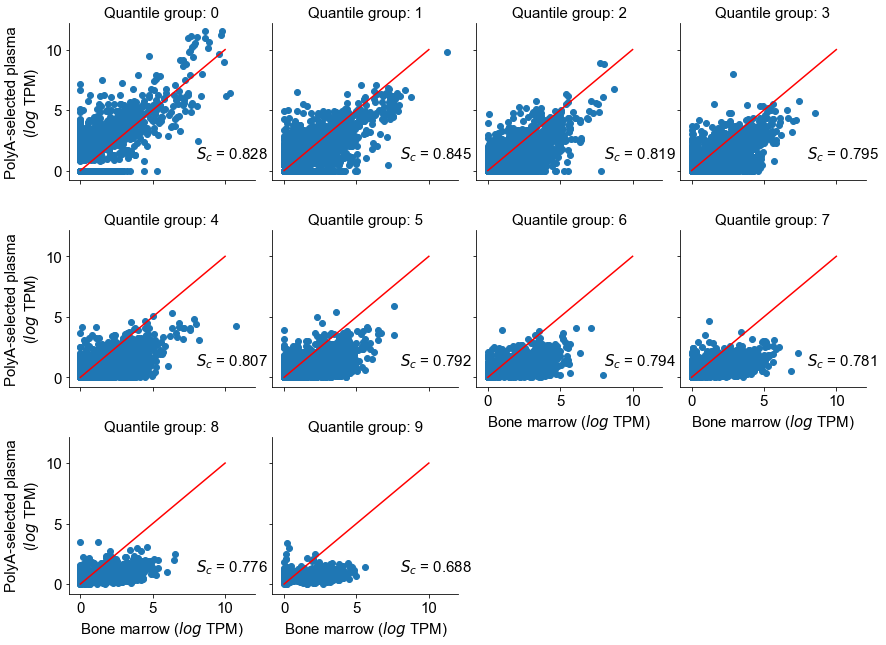

In [176]:
from scipy.stats import pearsonr

plot_qcut = qcut_expr_df\
                      .assign(plasma = lambda d: d['Qcf_L1_R1_001'].transform(lambda x: np.log(x+1)))\
                      .assign(bone = lambda d: d['bone marrow'].transform(lambda x: np.log(x+1)))\
                      .sort_values('ntile')
p = sns.FacetGrid(data = plot_qcut, 
                  col = 'ntile', col_wrap = 4)
p.map(plt.scatter, 'bone', 'plasma')
p.set_titles('{col_name}')
p.set_axis_labels('Bone marrow ($log$ TPM)', 'PolyA-selected plasma\n($log$ TPM)')

for ax in p.fig.axes:
    ax.plot([0,10],[0,10], color='red')
    
    data = plot_qcut.query("ntile == '%s'" %(ax.title.get_text()))
    cor_coef = cosine_similarity(data['plasma'].values.reshape(1,-1), 
                                       data['bone'].values.reshape(1,-1))
    ax.text(8, 1, r'$S_c$ = %.3f' %cor_coef, fontsize=15)
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.title

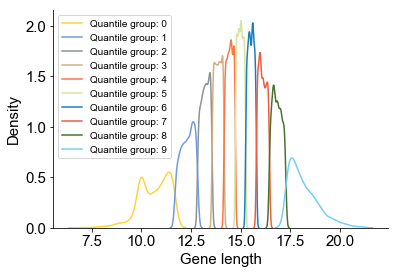

In [150]:
fig = plt.figure()
ax = fig.add_subplot(111)
colors = simpsons_palette()
for col, (gl, gl_df) in zip(colors, qcut_expr_df.groupby('ntile')):
    sns.distplot(np.log2(gl_df.glength), 
                 ax = ax, 
                 color = col,
                 label = gl,
                hist=False)
ax.set_xlabel('Gene length')
ax.set_ylabel('Density')
sns.despine()